In [1]:
import os
import numpy as np
import pandas
import random
import itertools
from operator import itemgetter, attrgetter

from matplotlib import pyplot
from collections import defaultdict, OrderedDict
from itertools import chain
from ete3 import Tree, TreeStyle, faces, AttrFace

from scipy import ndimage as ndimage

from ntb.constants import *
from ntb.db import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

# NTB database analysis

In [2]:
db = NTBDB()

In [3]:
print 'Number of categories:', len(db.by_tag)

Number of categories: 3006


In [5]:
top_tags = sorted(map(lambda (tag, pics): (tag, len(pics)), db.by_tag.iteritems()), key=itemgetter(1), reverse=True)

In [6]:
for t, count in top_tags[:50]:
    print t, count

alone 241464
action 159442
footbal 149250
full-length-portrait 97832
joy 96092
portrait 84742
press-conferences 71024
the-norwegian-royal-family 64416
cross-country-skiing 36973
illustration-photos 23796
team-handball 23475
training 23347
court-cases 22149
football-coaches 21900
olympic-games 21067
political-meetings 20041
travel-abroad 17934
families 17215
gesticulating 17070
biathlon 16340
exteriors 15758
women 15480
television-programmes 14654
meetings-and-conferences 14212
concerts 14069
events 13778
jubilees 13371
handshake 13364
travel-in-norway 13300
prize-awards 13123
spectators 12990
finance-and-business-and-industry 12557
advance-material 12280
ski-jumping 12170
murder 11949
serious 11438
children 11268
skiing 11114
state-visits 10908
disappointment 10874
goalkeepers 10625
athletics 10518
icehockey 10424
terrorism 10285
profile 10229
music-competition 10206
wide-shots 10068
interior 9675
embraces 9443
coaches 9418


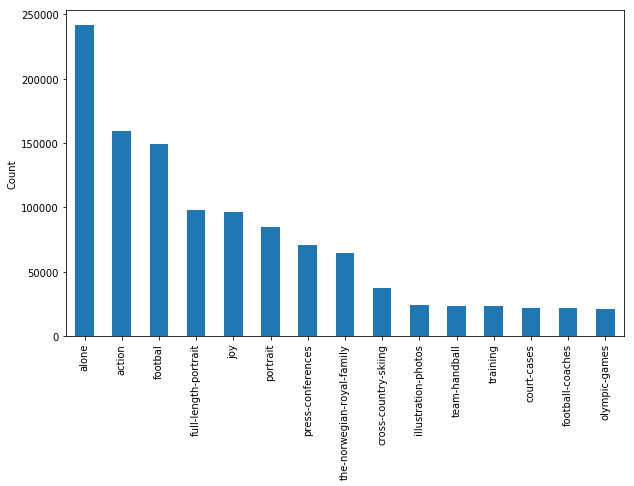

In [7]:
df = pandas.DataFrame.from_dict(OrderedDict(top_tags[:15]), orient='index')
plot = df.plot(kind='bar', legend=False)
plot.set_ylabel('Count')

In [8]:
def plot_distribution(tag_name, normalize=False, limit=20):
    tags = [t.name for t in db.tags.search_nodes(name=tag_name)[0].get_descendants()]
    data = sorted([(tag, len(db.by_tag.get(tag, []))) for tag in tags], key=itemgetter(1), reverse=True)
    if normalize:
        total_cnt = sum(map(itemgetter(1), data))
        data = [(tag, float(cnt) / total_cnt * 100) for (tag, cnt) in data]
    data = data[:limit]
    df = pandas.DataFrame.from_dict(OrderedDict(data), orient='index')
    plot = df.plot(kind='bar', legend=False)
    if normalize:
        plot.set_ylabel('Percent')
    else:
        plot.set_ylabel('Count')
    return plot

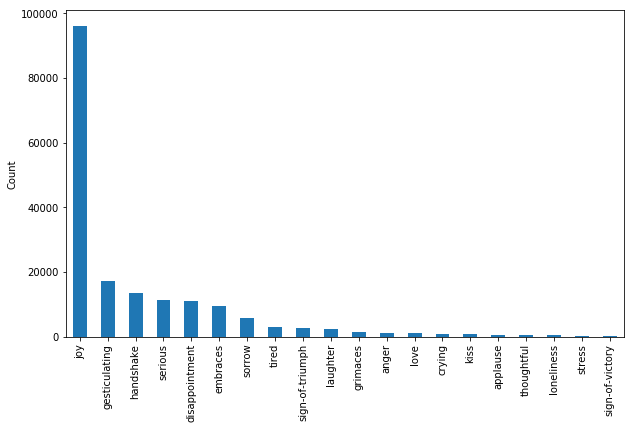

In [9]:
plot_distribution('moods-and-body-language')

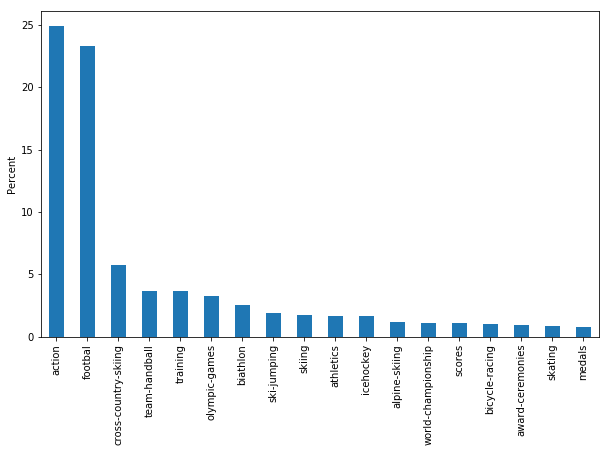

In [10]:
plot_distribution('sports', True)

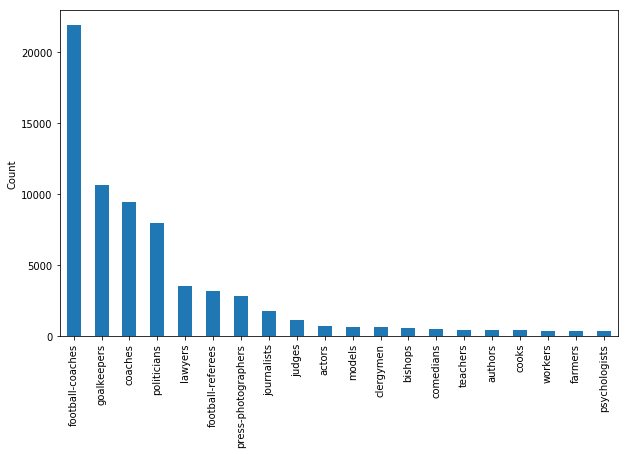

In [11]:
plot_distribution('professions')

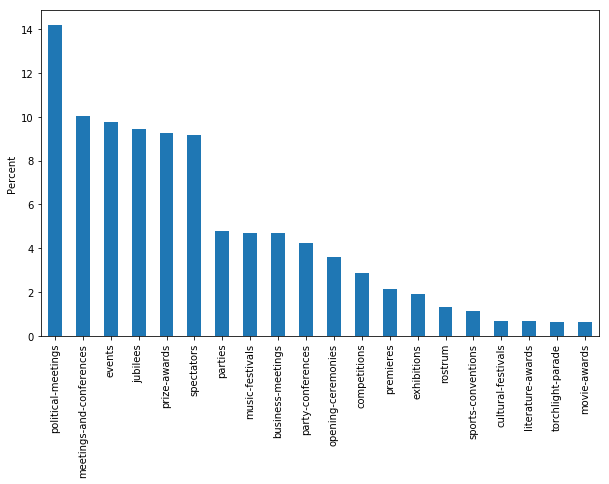

In [12]:
plot_distribution('meetings-conferences-and-events', True)

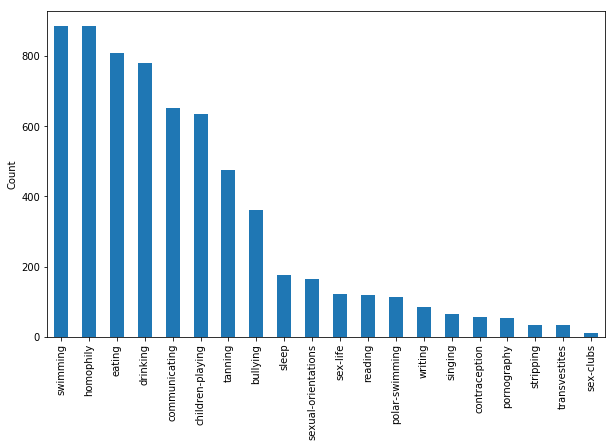

In [13]:
plot_distribution('human-actions')

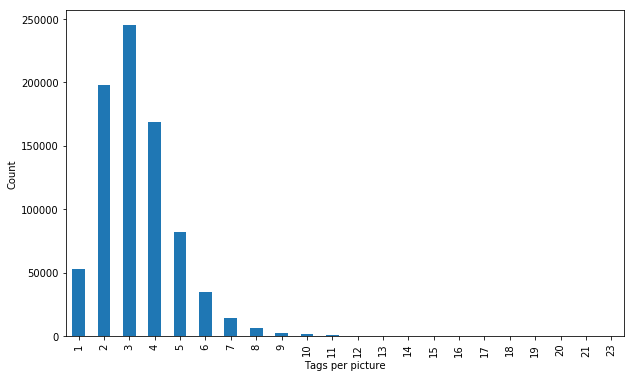

In [14]:
tags_per_pic = defaultdict(int)
for p in db.metadata.itervalues():
    if len(p['tags']) > 0:
        tags_per_pic[len(p['tags'])] += 1
tags_per_pic = dict(tags_per_pic)
df = pandas.DataFrame.from_dict(tags_per_pic, orient='index')
plot = df.plot(kind='bar', legend=False)
plot.set_ylabel('Count')
plot.set_xlabel('Tags per picture')

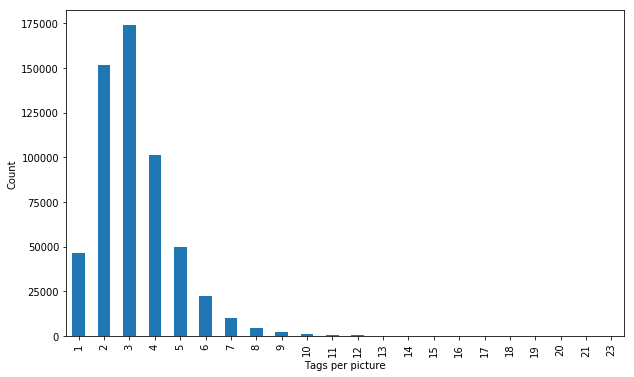

In [15]:
tags_per_pic = defaultdict(int)
for p in db.metadata.itervalues():
    if len(p['tags']) > 0  and 'alone' not in p['tags']:
        tags_per_pic[len(p['tags'])] += 1
tags_per_pic = dict(tags_per_pic)
df = pandas.DataFrame.from_dict(tags_per_pic, orient='index')
plot = df.plot(kind='bar', legend=False)
plot.set_ylabel('Count')
plot.set_xlabel('Tags per picture')

In [16]:
pics_with_tags_num =  len(filter(lambda p: p['tags'], db.metadata.itervalues()))
print "Pictures total: ", len(db.metadata), "With tags: ", pics_with_tags_num, 'Not alone:', sum(tags_per_pic.values())
multiple_tags_num = sum(tags_per_pic.values()) - tags_per_pic[1]
print "Multiple tags: {0:.1f}%".format(float(multiple_tags_num) / pics_with_tags_num * 100.0)

Pictures total:  913434 With tags:  806930 Not alone: 565466
Multiple tags: 64.3%


In [17]:
def show_tag_tree(tree, dst='%%inline'):
    def my_layout(node):
        if node.name:
            faces.add_face_to_node(AttrFace("name"), node, column=0, position="branch-right")
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.layout_fn = my_layout
    return tree.render(dst, tree_style=ts)

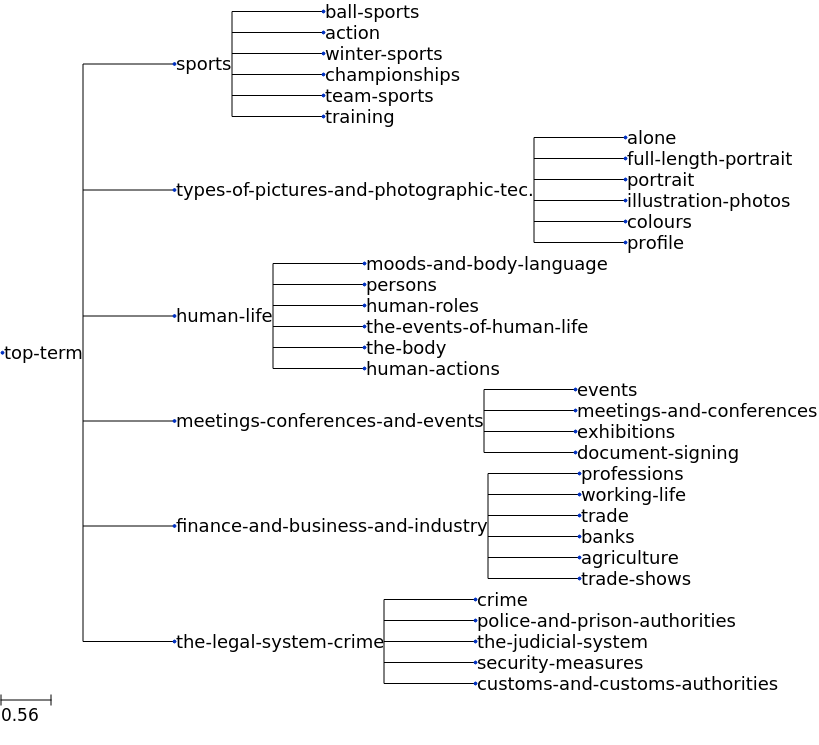

In [20]:
show_tag_tree(db.top_tags(max_children=6, max_depth=2))

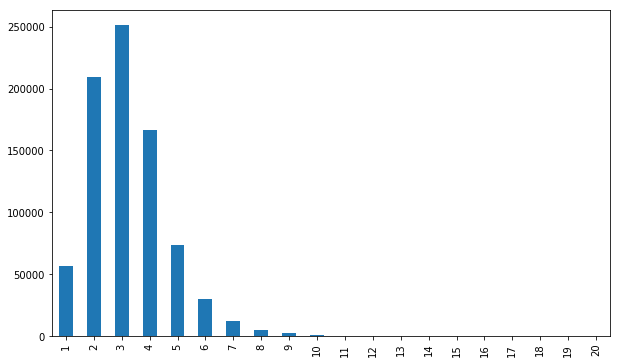

In [21]:
parents = {}
for n in db.tags.traverse():
    parents[n.name] = map(lambda n: n.name, n.get_ancestors())

uniq_tags_per_pic = defaultdict(int)
for p in db.metadata.itervalues():
    tags = set(p['tags'])
    for tag_name in p['tags']:
        if tags:
            tags = tags.difference(parents.get(tag_name, []))
        else:
            break
    if len(tags) > 0:
        uniq_tags_per_pic[len(tags)] += 1

df = pandas.DataFrame.from_dict(uniq_tags_per_pic, orient='index')
df.plot(kind='bar', legend=False)

In [28]:
print "Seasons: ", len(db.by_tag_with_children('seasons'))
print "Actions: ", len(db.by_tag_with_children('human-actions'))
sports_cnt = len(db.by_tag_with_children('sports'))
football_cnt = len(db.by_tag_with_children('footbal'))
print "Sports: ", sports_cnt, "({:.1f}% football)".format(float(football_cnt) / sports_cnt * 100)
print "Moods and body language: ", tag_cnt_with_children('moods-and-body-language')

Seasons:  13908
Actions:  6531
Sports:  641289 (23.6% football)
Moods and body language:  180056


In [31]:
print 'Skiing types:',  ', '.join(map(attrgetter('name'), db.tags.search_nodes(name='skiing')[0].get_descendants()))

Skiing types: alpine-skiing, nordic-skiing, biathlon, freeskiing, freestyle-skiing, slalom, snowboarding, giant-slalom, super-g, telemark-skiiing, downhill-skiing, nordic-combined, cross-country-skiing, ski-jumping, ski-orienteering, long-distance-ski-races, ski-flying


In [32]:
portraits_tags = {'portrait', u'press-conferences', u'coaches'}
skiing_pics = db.by_tag_with_children('skiing')
skiing_pics_portraits = filter(lambda p: portraits_tags.intersection(p['tags']), skiing_pics)
print """
Skiing total: {total}
From them [{excluding}]: {total_excluding} ({rate:.1f}%)
""".format(
    total=len(skiing_pics),
    excluding=', '.join(portraits_tags),
    total_excluding=len(skiing_pics_portraits),
    rate=float(len(skiing_pics_portraits)) / len(skiing_pics) * 100
)


Skiing total: 97436
From them [coaches, press-conferences, portrait]: 12348 (12.7%)

